# Behavioral Cloning for Autonomous Vehicles - Training

Ignore warnings.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Dependencies

Import libraries.

In [2]:
import os
import ntpath
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

Configure TensorFlow GPU.

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

## Read Driving Log

Import and read `Driving-Log.csv`.

In [4]:
def shorten_path(path):
    '''
    Function to view shortened paths.
    '''
    head,tail = ntpath.split(path)
    return tail

In [5]:
# Define data directory
data_directory = 'Dataset'

# Read the driving log
headers = ['Center Frame', 'Left Frame', 'Right Frame', 'Steering Angle', 'Throttle', 'Brake','Speed']
driving_log = pd.read_csv(os.path.join(data_directory,'Driving-Log.csv'), names = headers)
pd.set_option('display.max_colwidth', -1)

# Shorthen the paths
driving_log['Center Frame'] = driving_log['Center Frame'].apply(shorten_path)
driving_log['Left Frame'] = driving_log['Left Frame'].apply(shorten_path)
driving_log['Right Frame'] = driving_log['Right Frame'].apply(shorten_path)

# View the first 5 entries in the dataframe
driving_log.head()

,Center Frame,Left Frame,Right Frame,Steering Angle,Throttle,Brake,Speed
0,Center_Frame_2019_08_10_18_29_45_626.jpg,Left_Frame_2019_08_10_18_29_45_626.jpg,Right_Frame_2019_08_10_18_29_45_626.jpg,0.0,0.4,0,2.760634
1,Center_Frame_2019_08_10_18_29_45_692.jpg,Left_Frame_2019_08_10_18_29_45_692.jpg,Right_Frame_2019_08_10_18_29_45_692.jpg,0.0,0.4,0,3.024059
2,Center_Frame_2019_08_10_18_29_45_763.jpg,Left_Frame_2019_08_10_18_29_45_763.jpg,Right_Frame_2019_08_10_18_29_45_763.jpg,0.0,0.4,0,3.388839
3,Center_Frame_2019_08_10_18_29_45_832.jpg,Left_Frame_2019_08_10_18_29_45_832.jpg,Right_Frame_2019_08_10_18_29_45_832.jpg,0.0,0.4,0,3.676442
4,Center_Frame_2019_08_10_18_29_45_901.jpg,Left_Frame_2019_08_10_18_29_45_901.jpg,Right_Frame_2019_08_10_18_29_45_901.jpg,0.0,0.4,0,4.031865


## Load Data

Load minimal data so as to reduce memory footprint.

In [6]:
def load_data(data_directory, dataframe):
    '''
    Loads `steering_angles` from `dataframe` and `frames` as paths to center frames
    by preceeding center frame names from `dataframe` by `data_directory`.
    
    Note: `frames[i]` can be modified later to define path to left or right frames.
    '''
    frame = []
    steering_angle = []
    for i in range(len(dataframe)):
        indexed_data = dataframe.iloc[i]
        frame.append(os.path.join(data_directory, indexed_data[0].strip())) # Load only center frame paths
        steering_angle.append(float(indexed_data[3])) # Load steering angles
    frames = np.asarray(frame)
    steering_angles = np.asarray(steering_angle)
    return frames, steering_angles

In [7]:
# Load data
frames, steering_angles = load_data(data_directory+'/Camera-Frames', driving_log)

In [8]:
# Free up memory by nullifying `driving_log`
driving_log = None

## Data Augmentation

Define and test the augmentation techniques. Actual data augmentation will be performed in `batch_generator`.

### Pan

In [9]:
error_pan_x_limits = "The x_percent_min value must be <= x_percent_max value"
error_pan_y_limits = "The y_percent_min value must be <= y_percent_max value"

def pan(image, x_percent_min=-0.1, x_percent_max=0.1, y_percent_min=-0.1, y_percent_max=0.1):
    '''
    Given an `image`, pans it horizontally by a random value (in %) between `x_percent_min` and `x_percent_max`
    and vertically by a random value (in %) between `y_percent_min` and `y_percent_max`. Then, performs cropping
    such that no black borders are left, and finally resizes it to the original dimensions.
    
    Note: Resizing operation may blur the image.
    '''
    if(x_percent_min>x_percent_max):
        raise Exception(error_pan_x_limits)
    if(y_percent_min>y_percent_max):
        raise Exception(error_pan_y_limits)
    x_percent = np.random.uniform(x_percent_min,x_percent_max)
    y_percent = np.random.uniform(y_percent_min,y_percent_max)
    h, w = image.shape[:2]
    h_shift, v_shift = int(w*x_percent) , int(h*y_percent)
    trans_matrix = np.float32([[1, 0, h_shift], [0, 1, v_shift]])
    panned_image = cv2.warpAffine(image, trans_matrix, (w, h))
    if h_shift>=0:
        if v_shift>=0:
            cropped_image = panned_image[v_shift:h, h_shift:w]
        if v_shift<0:
            cropped_image = panned_image[0:h+v_shift, h_shift:w]
    if h_shift<0:
        if v_shift>=0:
            cropped_image = panned_image[v_shift:h, 0:w+h_shift]
        if v_shift<0:
            cropped_image = panned_image[0:h+v_shift, 0:w+h_shift]
    panned_image = cv2.resize(cropped_image,(w,h))
    return panned_image

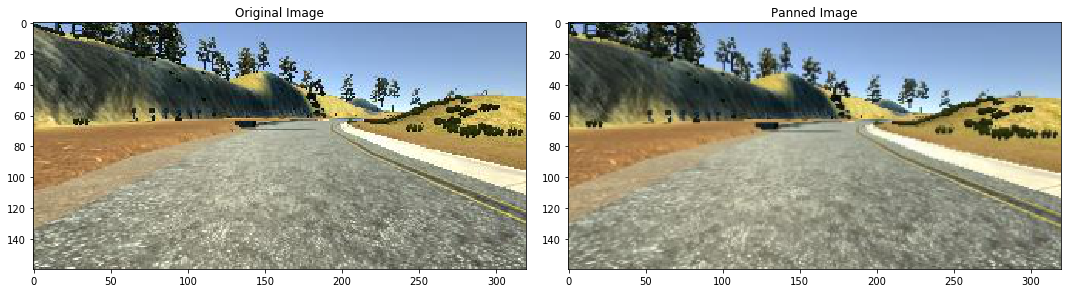

In [10]:
# Test `pan()` on a random image
image = frames[random.randint(0, len(frames)-1)]
original_image = mpimg.imread(image)
panned_image = pan(original_image, -0.05, 0.05, -0.05, 0.05) # Pan by + or - 5 percent horizontally and vertically

# Visualize the original and panned images side-by-side
figure, axes = plt.subplots(1, 2, figsize = (15, 10))
figure.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(panned_image)
axes[1].set_title('Panned Image')
plt.show()

### Tilt

In [11]:
error_tilt_limits = "The angle_min value must be <= angle_max value"

def tilted_rectangle_with_max_area(w, h, angle):
    '''
    Given a rectangle of size (`w` x `h`) that has been rotated by `angle` (in degrees), computes
    the width and height of the largest possible axis-aligned rectangle (maximal area) within the
    rotated rectangle.
    '''
    angle = np.deg2rad(angle)
    if w <= 0 or h <= 0:
        return 0,0
    width_is_longer = w >= h
    side_long, side_short = (w,h) if width_is_longer else (h,w)
    
    # Since the solutions for (angle), (-angle) and (180-angle) are all the same, it
    # suffices to look at the first quadrant and the absolute values of sin and cos.
    sin_a, cos_a = abs(np.sin(angle)), abs(np.cos(angle)) 
    
    # Half-constrained case: 
    # Two crop corners touch the longer side, the other two corners are on the mid-line parallel to the longer line.
    if side_short <= 2.*sin_a*cos_a*side_long or abs(sin_a-cos_a) < 1e-10: 
        x = 0.5*side_short
        wr,hr = (x/sin_a,x/cos_a) if width_is_longer else (x/cos_a,x/sin_a)
    # Fully-constrained case:
    # Crop touches all 4 sides.
    else:
        cos_2a = cos_a*cos_a - sin_a*sin_a
        wr,hr = (w*cos_a - h*sin_a)/cos_2a, (h*cos_a - w*sin_a)/cos_2a
    return wr,hr

def crop_around_center(image, w, h):
    '''
    Given an `image`, crops it to the given width `w` and height `h`, about it's centre point.
    '''
    image_size = (image.shape[1], image.shape[0])
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))
    if(w > image_size[0]):
        w = image_size[0]
    if(h > image_size[1]):
        h = image_size[1]
    x1 = int(image_center[0] - w * 0.5)
    x2 = int(image_center[0] + w * 0.5)
    y1 = int(image_center[1] - h * 0.5)
    y2 = int(image_center[1] + h * 0.5)
    return image[y1:y2, x1:x2]

def tilt(image, angle_min=-5, angle_max=5, center=None, scale=1.0):
    '''
    Given an `image`, tilts it by a random angle (in degrees) between `angle_min` and `angle_max` and
    performs cropping such that no black borders are left, then resizes it to the original dimensions.
    
    Note: Resizing operation may blur the image.
    '''
    if(angle_min>angle_max):
        raise Exception(error_tilt_limits)
    angle = np.random.uniform(angle_min,angle_max)
    (h, w) = image.shape[:2]
    if center is None:
        center = (w/2, h/2)
    rot_matrix = cv2.getRotationMatrix2D(center, angle, scale) # Compute 2D rotation matrix
    rotated_image = cv2.warpAffine(image, rot_matrix, (w, h)) # Perform the rotation
    wr,hr = tilted_rectangle_with_max_area(w, h, angle) # Compute cropping limits
    cropped_image = crop_around_center(rotated_image, wr, hr) # Crop the image to given limits about center
    tilted_image = cv2.resize(cropped_image,(w,h)) # Resize to original dimensions and append to image array
    return tilted_image

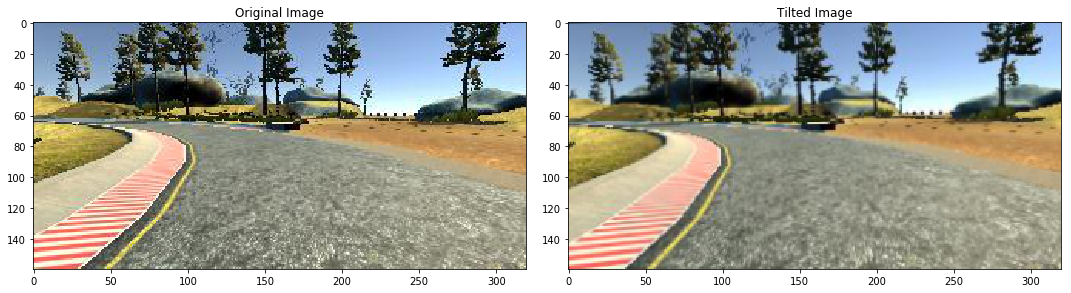

In [12]:
# Test `tilt()` on a random image
image = frames[random.randint(0, len(frames)-1)]
original_image = mpimg.imread(image)
tilted_image = tilt(original_image, -1, 1) # Tilt by + or - 1 degree

# Visualize the original and tilted images side-by-side
figure, axes = plt.subplots(1, 2, figsize = (15, 10))
figure.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(tilted_image)
axes[1].set_title('Tilted Image')
plt.show()

### Probabilistic Augmentation

In [13]:
def data_augmentor(image, steering_angle):
    '''
    Probabilistically applies the augmentation techniques defined earlier.
    
    Note: Decide the sequency of augmentation carefully (some augmentations are better applied before/after other augmentations).
    Note: Tune the probability values according to the expected variations in the environment.
    '''
      
    image = mpimg.imread(image) # Read image
    
    if np.random.rand() <= 0.5: # 50% probability
        image = pan(image, -0.05, 0.05, -0.05, 0.05) # Pan the image by + or - 5 percent horizontally and vertically 
        
    if np.random.rand() <= 0.5: # 50% probability
        image = tilt(image, -1, 1) # Tilt the image by + or - 1 degree
        
    return image, steering_angle

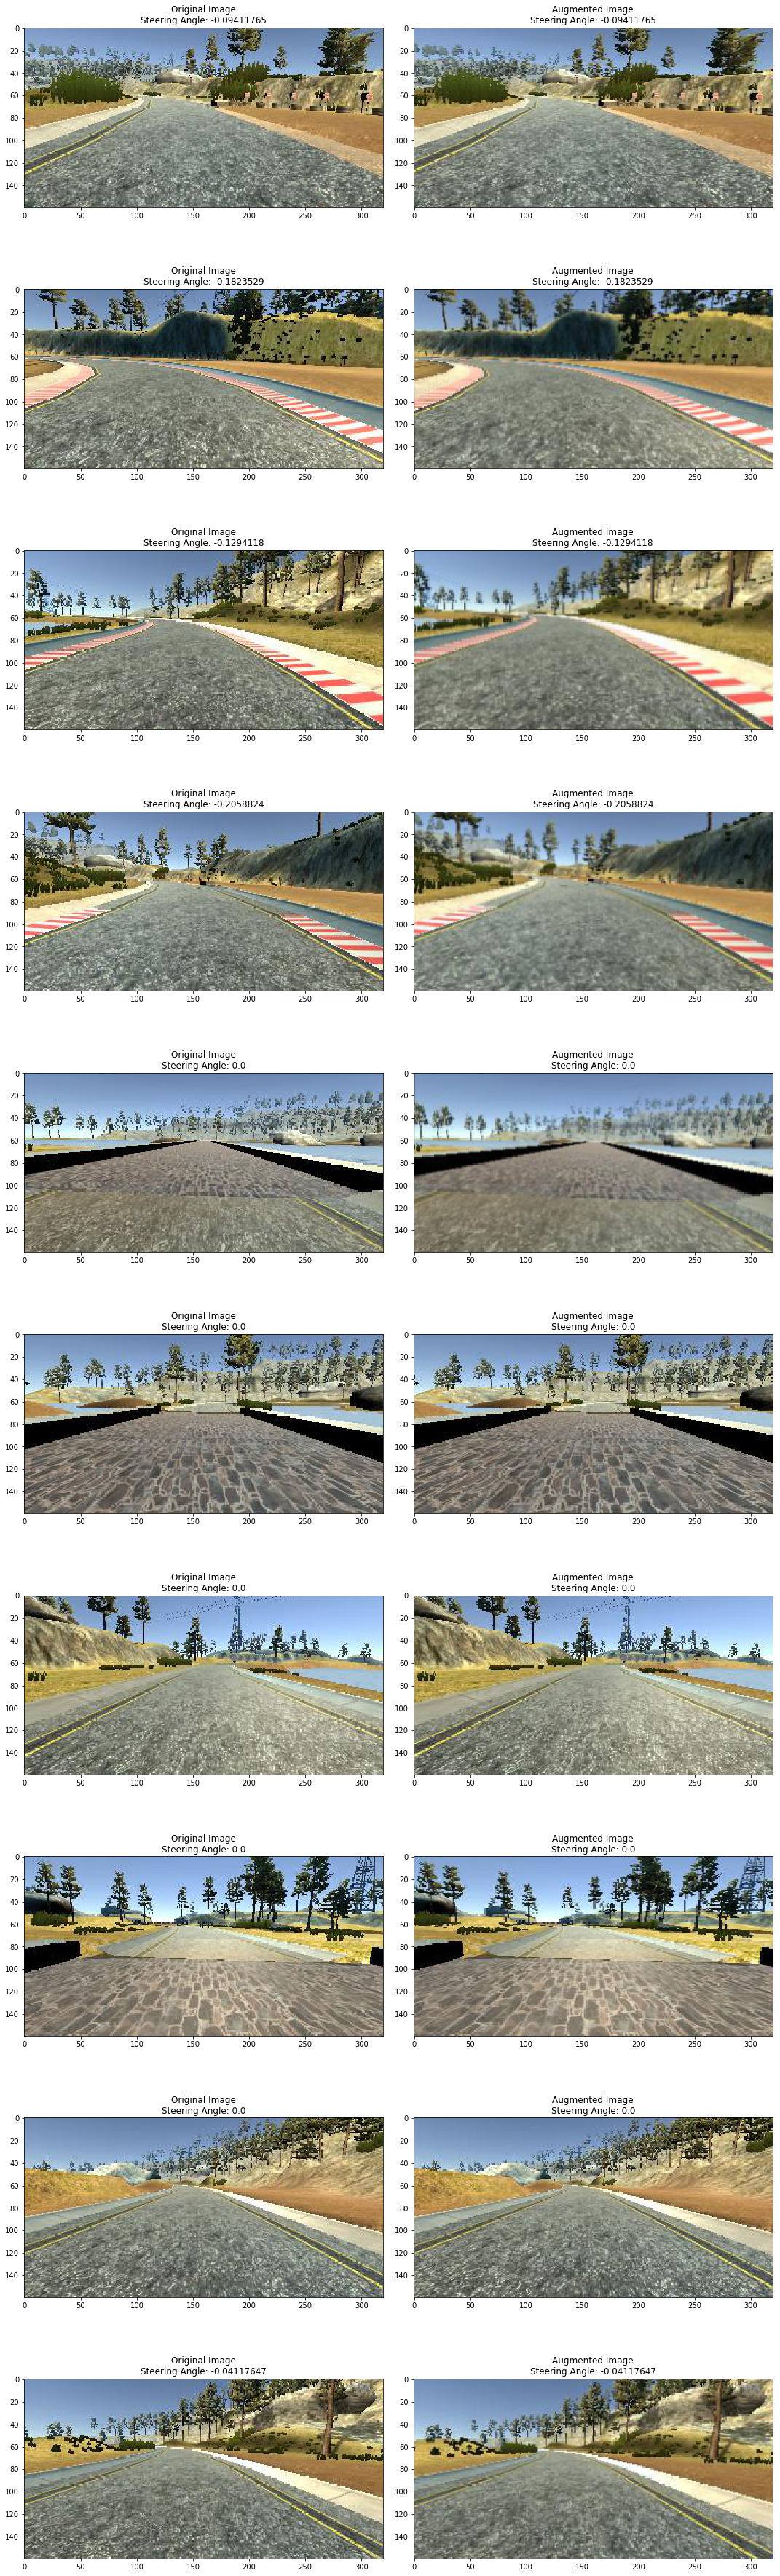

In [14]:
ncol = 2
nrow = 10

figure, axes = plt.subplots(nrow, ncol, figsize = (15, 50))
figure.tight_layout()

for i in range(10):
    # Test `data_augmentor()` on 10 random images
    random_index = random.randint(0, len(frames)-1)
    image = frames[random_index]
    steering_angle = steering_angles[random_index]
    original_image = mpimg.imread(image)
    augmented_image, corrected_steering_angle = data_augmentor(image, steering_angle)
    
    # Visualize the original and augmented images side-by-side
    axes[i][0].imshow(original_image)
    axes[i][0].set_title('Original Image\n' + 'Steering Angle: ' + str(steering_angle))
    axes[i][1].imshow(augmented_image)
    axes[i][1].set_title('Augmented Image\n' + 'Steering Angle: ' + str(corrected_steering_angle))
    
plt.show()

## Data Preprocessing

Define and test the preprocessing pipeline. Actual preprocessing will be performed in `batch_generator`.

In [15]:
def data_preprocessor(image):
    '''
    Preprocesses the input `image` by applying a series of image processing techniques.
    '''
    image = image[60:160,:,:] # ROI masking (remove the sky and other unwanted environment)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV) # Convert RGB to YUV (recommended by the NVIDIA model)
    image = cv2.resize(image, (200, 66)) # Resize the image (resize the image to the input shape used by the neural model)
    image = image/255.0 # Normalization
    return image

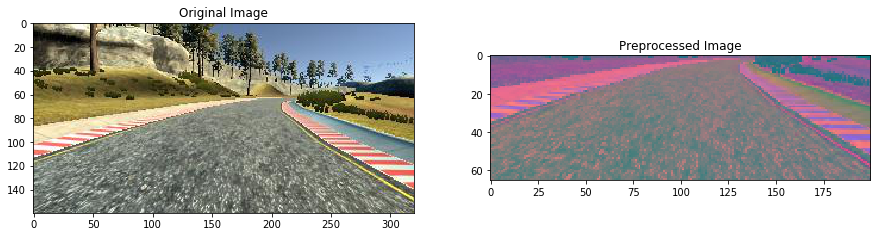

In [16]:
# Test `data_preprocessor()` on a random image
image = frames[random.randint(0, len(frames)-1)]
original_image = mpimg.imread(image)
preprocessed_image = data_preprocessor(original_image)

# Visualize the original and preprocessed images side-by-side
figure, axes = plt.subplots(1, 2, figsize = (15, 10))
figure.tight_layout
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')
plt.show()

## Data Segregation

Split the dataset into `train` and `test` sets. The `train` set will be used to train the neural network, while the `test` set will be used to validate its performance.

In [17]:
def data_segregator(frames, steering_angles, test_size=0.2):
    '''
    Splits the dataset (`frames`, `steering_angles`) into train and test sets with the specified `test_size`.
    `frames` are returned as `x_train` and `x_test` whereas corresponding `steering_angles` are returned as
    `y_train` and `y_test`.
    
    Note: `train_size` = 1 - `test_size`.
    '''
    x_train, x_test, y_train, y_test = train_test_split(frames, steering_angles, test_size = test_size, random_state = 1)
    print('Training Samples: {}\nTesting Samples: {}'.format(len(x_train), len(x_test)))
    return x_train, x_test, y_train, y_test

Training Samples: 9680
Testing Samples: 2421


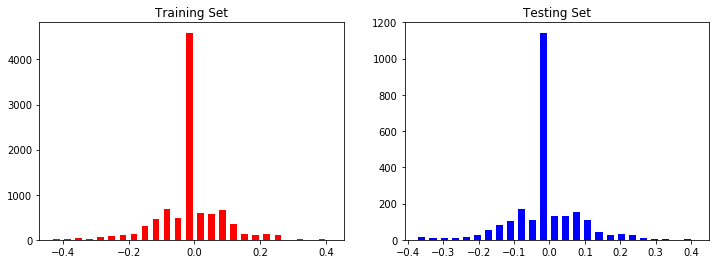

In [18]:
# Segregate the dataset into training and testing datasets
x_train, x_test, y_train, y_test = data_segregator(frames, steering_angles, test_size=0.2) # 80:20 split

# Visualize the histograms of training and testing datasets side-by-side
figure, axes = plt.subplots(1, 2, figsize = (12, 4))
axes[0].hist(y_train, bins = 25, width = 0.02, color = 'red')
axes[0].set_title('Training Set')
axes[1].hist(y_test, bins = 25, width = 0.02, color = 'blue')
axes[1].set_title('Testing Set')
plt.show()

In [19]:
# Free up memory by nullifying `frames` and `steering_angles`
frames, steering_angles = None, None

## Batch Generator

Define a `batch_generator` to continuously yield training and testing batches. Augmentation and preprocessing is done on-the-go in order to reduce memory footprint.

In [20]:
def batch_generator(frames, steering_angles, batch_size, is_training):
    '''
    Generates batches (`batch_frames`, `batch_angles`) of size `batch_size` using the input features `frames`
    and labels `steering_angles`. The `is_training` flag allows certain operations such as augmentation, etc.
    to be performed only during training, whereas other operations such as data preprocessing are performed
    during training as well as testing.
    '''
    
    # Do the following while total number of samples generated is lower than the number of 'samples_per_epoch'
    while True:

        # Do the following everytime when looping through the dataset
        if is_training:
            # Shuffle the dataset
            frames, steering_angles = shuffle(frames, steering_angles)
            # Define largest possible `data_size` divisible by `batch_size`
            data_size = len(frames) - len(frames)%batch_size
        else:
            # Define largest possible `data_size` divisible by `batch_size`
            data_size = len(frames) - len(frames)%batch_size
        
        # Loop through the entire dataset with an increment of `batch_size`
        for offset in range(0, data_size, batch_size):
            # Create empty lists to store batch data
            batch_frames = []
            batch_angles = []
            
            # Loop to generate a batch of (`batch_frames`, `batch_angles`)
            for i in range(batch_size):
                if is_training:
                    # Perform augmentation only when training
                    frame, angle = data_augmentor(frames[offset:offset+batch_size][i], steering_angles[offset:offset+batch_size][i])
                else:
                    # Simply read the recorded frame and corresponding steering angle during testing
                    frame = mpimg.imread(frames[offset:offset+batch_size][i])
                    angle = steering_angles[offset:offset+batch_size][i]
                
                # Preprocess the frame (during both training and testing)
                frame = data_preprocessor(frame)
                
                # Prepare a batch
                batch_frames.append(frame)
                batch_angles.append(angle)
                
            # Yield a batch
            yield (np.asarray(batch_frames), np.asarray(batch_angles))

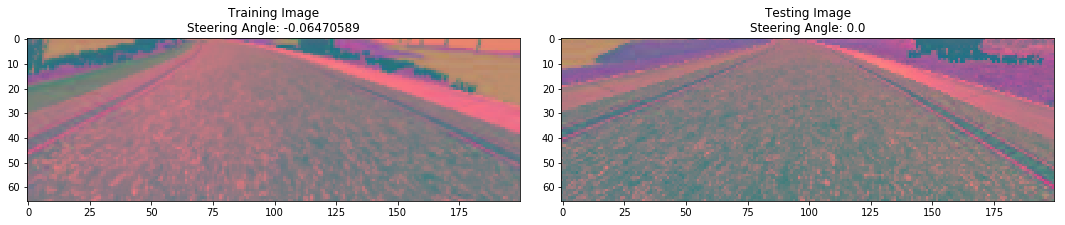

In [21]:
# Generate a train and test batch
x_train_gen, y_train_gen = next(batch_generator(x_train, y_train, 1, 1))
x_test_gen, y_test_gen = next(batch_generator(x_test, y_test, 1, 0))
figure, axes = plt.subplots(1, 2, figsize = (15, 10))
figure.tight_layout()

# Visualize the training and testing images side-by-side
axes[0].imshow(x_train_gen[0])
axes[0].set_title('Training Image\n' + 'Steering Angle: ' + str(y_train_gen[0]))
axes[1].imshow(x_test_gen[0])
axes[1].set_title('Testing Image\n' + 'Steering Angle: ' + str(y_test_gen[0]))
plt.show()

## Neural Network Model

Define a neural network model and compile it. Also generate a brief summary and a plot of the model.

In [22]:
def model():
    model = Sequential()
    model.add(Convolution2D(24, (5, 5), strides = (2, 2), input_shape = (66, 200, 3), activation = 'relu', name = 'CONV1'))
    model.add(Convolution2D(36, (5, 5), strides = (2, 2), activation = 'relu', name = 'CONV2'))
    model.add(Convolution2D(48, (5, 5), strides = (2, 2), activation = 'relu', name = 'CONV3'))
    model.add(Convolution2D(64, (3, 3), activation = 'relu', name = 'CONV4'))
    model.add(Convolution2D(64, (3, 3), activation = 'relu', name = 'CONV5'))
    #model.add(Dropout(0.25, name = 'DROP1'))
    model.add(Flatten(name = 'Flatten'))
    model.add(Dense(100, activation = 'relu', name = 'FC1'))
    #model.add(Dropout(0.25, name = 'DROP2'))
    model.add(Dense(50, activation = 'relu', name = 'FC2'))
    #model.add(Dropout(0.25, name = 'DROP3'))
    model.add(Dense(10, activation = 'relu', name = 'FC3'))
    #model.add(Dropout(0.25, name = 'DROP4'))
    model.add(Dense(1, name = 'FC4'))
    model.compile(loss = 'mse', optimizer = Adam(lr = 1e-3))
    return model

In [23]:
model = model() # Select model
print(model.summary()) # Model summary

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV1 (Conv2D)               (None, 31, 98, 24)        1824      
_________________________________________________________________
CONV2 (Conv2D)               (None, 14, 47, 36)        21636     
_________________________________________________________________
CONV3 (Conv2D)               (None, 5, 22, 48)         43248     
_________________________________________________________________
CONV4 (Conv2D)               (None, 3, 20, 64)         27712     
_________________________________________________________________
CONV5 (Conv2D)               (None, 1, 18, 64)         36928     
_________________________________________________________________
Flatten (Flatten)            (None, 1152)              0         
____

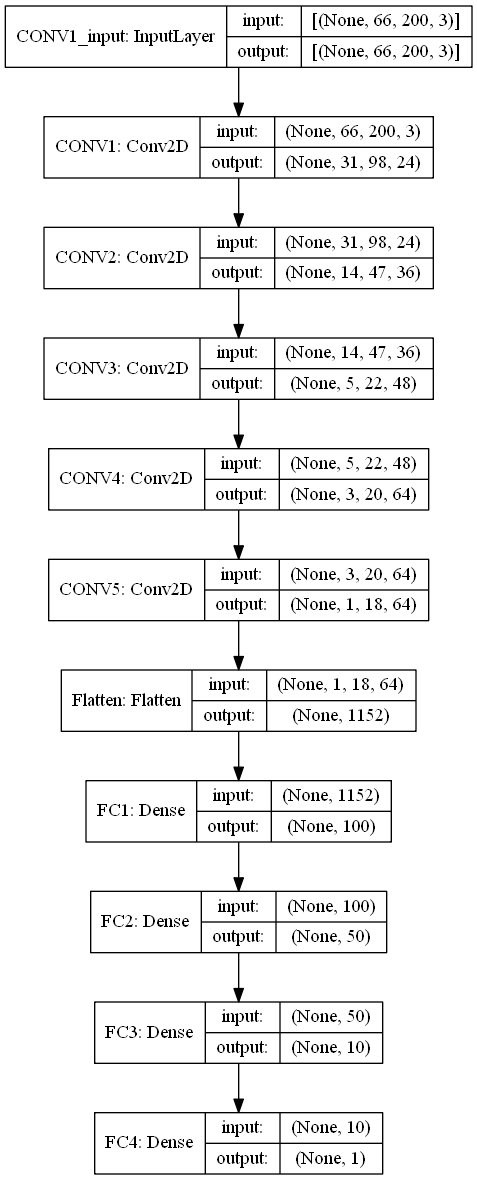

In [24]:
# Plot the model
plot_model(model, to_file='NVIDIA PilotNet Architecture.png', show_shapes=True, show_layer_names=True)

## Training

Train the neural network and analyze its performance. Finally, save the model as `NVIDIA_WDB_Simplistic_Driving_Behaviour_Model.h5`.

### Train the Model

In [25]:
# Training hyperparameters
epochs = 5 # Number of epochs
batch_size = 256 # Batch size
augmentation_loops = 64 # Number of times to loop through the dataset, performing random augmentations each time
train_steps = np.ceil(len(x_train)/batch_size) * augmentation_loops # Steps per epoch during training
test_steps = np.ceil(len(x_test)/batch_size) # Steps per epoch during testing

In [26]:
history = model.fit_generator(
                                batch_generator(x_train, y_train, batch_size = batch_size, is_training = 1),
                                steps_per_epoch = train_steps, 
                                epochs = epochs,
                                validation_data = batch_generator(x_test, y_test, batch_size = batch_size, is_training =  0),
                                validation_steps = test_steps,
                                verbose = 1,
                                shuffle = 1
                             )

Epoch 1/5
2432/2432 [==============================] - 1444s 594ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 2/5
2432/2432 [==============================] - 1308s 538ms/step - loss: 6.2698e-04 - val_loss: 0.0012
Epoch 3/5
2432/2432 [==============================] - 1319s 542ms/step - loss: 4.2089e-04 - val_loss: 0.0013
Epoch 4/5
2432/2432 [==============================] - 1294s 532ms/step - loss: 3.2818e-04 - val_loss: 0.0013
Epoch 5/5
2432/2432 [==============================] - 1236s 508ms/step - loss: 2.7117e-04 - val_loss: 0.0013


### Evaluation

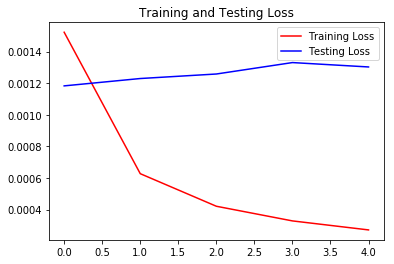

In [27]:
# Get training and testing losses for all the epochs from `history`
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

# Plot the training and testing loses
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Testing Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

### Save the Trained Model

In [28]:
model.save('NVIDIA_WDB_Simplistic_Driving_Behaviour_Model.h5')